In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os
from dotenv import load_dotenv

In [2]:
from pymongo import MongoClient

load_dotenv()
client = os.getenv("MONGO_URI")
client = MongoClient(client)
db = client["storage_simulation"]
collection = db["usage_logs"]

In [3]:
# Fetch all documents from the collection
cursor = collection.find()

# Convert to DataFrame
df = pd.DataFrame(list(cursor))
# Drop the '_id' column
df = df.drop(columns=['_id'])

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp (optional but good for plotting)
df = df.sort_values(by='timestamp')

In [4]:
info_df = df[df['directory'] == '/info'].copy()
customer_df = df[df['directory'] == '/customer'].copy()
scratch_df = df[df['directory'] == '/scratch'].copy()
projects_df = df[df['directory'] == '/projects'].copy()

In [5]:
# Helper function to create sequences
def create_sequences(data, input_seq_len, forecast_offset):
    X, y = [], []

    for i in range(len(data) - input_seq_len - forecast_offset):
        input_seq = data[i:i + input_seq_len]
        target = data[i + input_seq_len + forecast_offset - 1]  # eg.t+7
        X.append(input_seq)
        y.append(target)

    X = np.array(X).reshape(-1, input_seq_len, 1)  # Reshaping for LSTM
    y = np.array(y)
    return X, y

In [6]:
# Define LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Outputting a single value
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [12]:
def preprocess_and_train_month(df, name="Directory", input_seq_len=30, forecast_offset=30):
    # Ensure datetime index
    df.set_index('timestamp', inplace=True)

    # Remove redundant columns and aggregate by day if necessary
    df = df[['storage_gb']]
    df_daily = df.resample('D').mean()  # Aggregating by day

    # Scaling the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_daily.values).flatten()

    # Prepare sequences for model input
    X, y = create_sequences(scaled_data, input_seq_len, forecast_offset)

    # Train-test split (80% train, 20% test)
    split_idx = int(len(X) * 0.8)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    # Build the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (30, 1)
    model = build_lstm_model(input_shape)

    # EarlyStopping callback to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )

    # Predictions
    y_pred = model.predict(X_test)

    # Inverse transform the scaled data back to original values
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape for inverse transform
    y_pred_original = scaler.inverse_transform(y_pred)  # Reshape for inverse transform

    # Evaluate the model (RMSE, MAE)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae = mean_absolute_error(y_test_original, y_pred_original)
    # Calculate Normalized RMSE and MAE
    data_range = y_test_original.max() - y_test_original.min()
    normalized_rmse = rmse / data_range
    normalized_mae = mae / data_range

    print(f"\n📊 {name} - 1 Month Forecast Results:")
    print(f"   RMSE  : {rmse:.2f} GB")
    print(f"   MAE   : {mae:.2f} GB")
    print(f"   Normalized RMSE  : {normalized_rmse:.4f}")
    print(f"   Normalized MAE   : {normalized_mae:.4f}")

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_original, label='Actual')
    plt.plot(y_pred_original, label='Predicted')
    plt.title(f'{name} - 1 Month Ahead Forecast')
    plt.xlabel('Sample Index')
    plt.ylabel('Storage (GB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    models = os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))
    os.makedirs(models, exist_ok=True)
    model.save(os.path.join(models, f"{name}_monthly_forecast_model.keras"))

    scalers = os.path.abspath(os.path.join(os.getcwd(), '..', 'scalers'))
    os.makedirs(scalers, exist_ok=True)
    scaler_file_path = os.path.join(scalers, f"{name}_monthly_scaler.pkl")
    joblib.dump(scaler, scaler_file_path)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

📊 Customer - 1 Month Forecast Results:
   RMSE  : 136.92 GB
   MAE   : 111.95 GB
   Normalized RMSE  : 0.3722
   Normalized MAE   : 0.3043


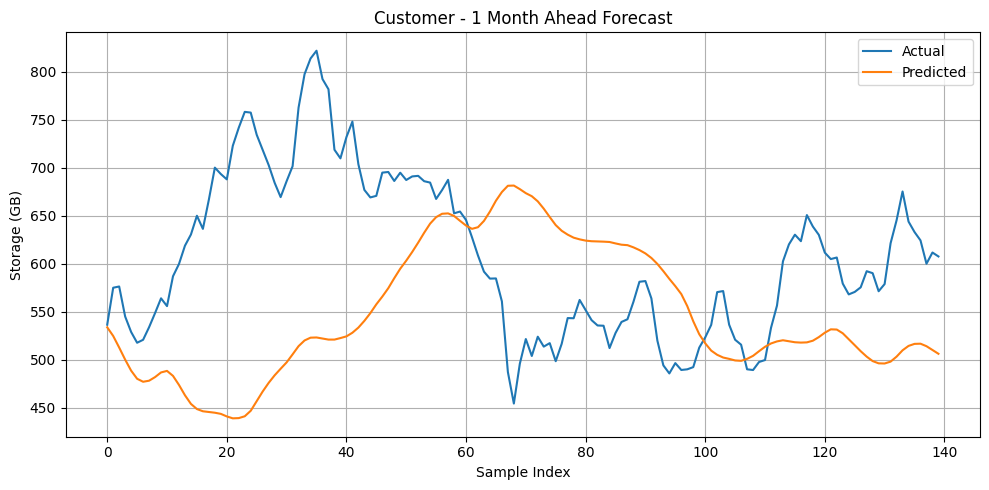

In [17]:
preprocess_and_train_month(customer_df.copy(), name='Customer', input_seq_len=30, forecast_offset=30)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

📊 Info - 1 Month Forecast Results:
   RMSE  : 65.82 GB
   MAE   : 54.39 GB
   Normalized RMSE  : 0.2471
   Normalized MAE   : 0.2042


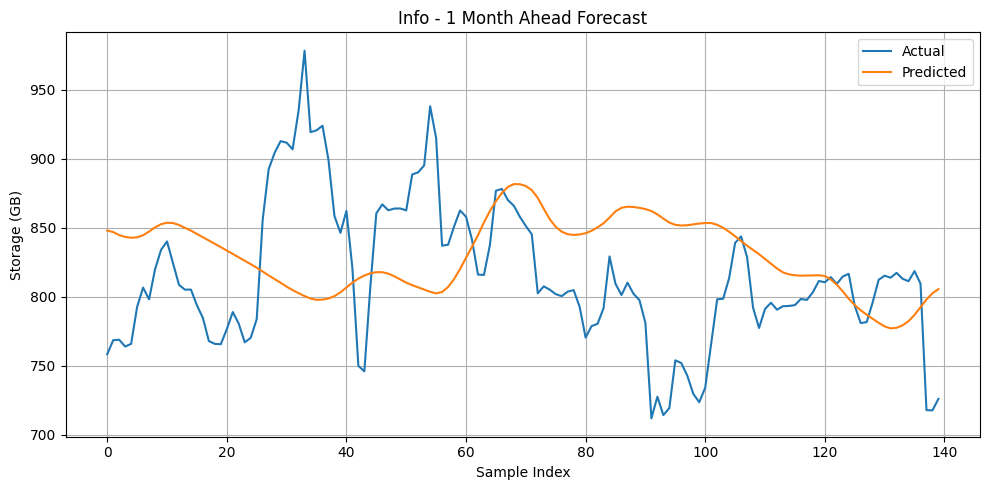

In [18]:
preprocess_and_train_month(info_df.copy(), name='Info', input_seq_len=30, forecast_offset=30)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

📊 Project - 1 Month Forecast Results:
   RMSE  : 246.19 GB
   MAE   : 211.18 GB
   Normalized RMSE  : 0.3608
   Normalized MAE   : 0.3095


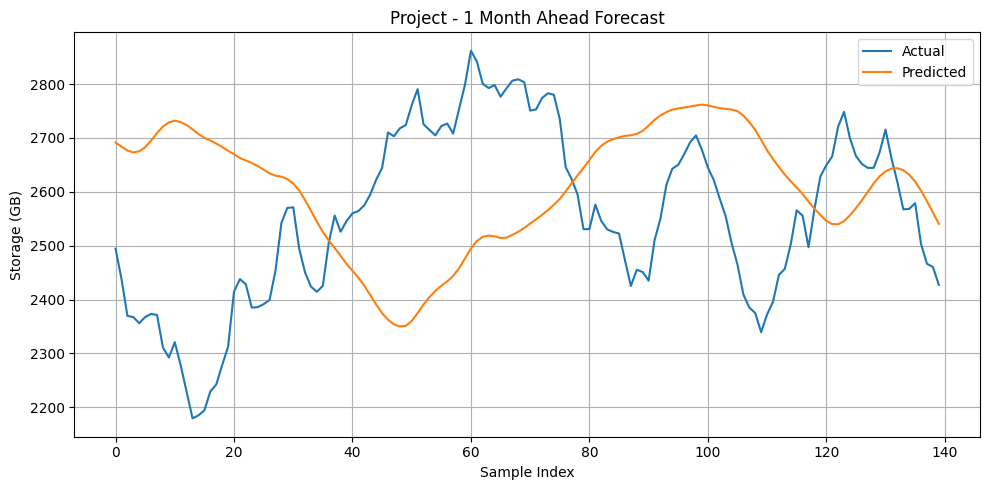

In [27]:
preprocess_and_train_month(projects_df.copy(), name='Project', input_seq_len=30, forecast_offset=30)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

📊 Scracth - 1 Month Forecast Results:
   RMSE  : 442.06 GB
   MAE   : 374.05 GB
   Normalized RMSE  : 0.2948
   Normalized MAE   : 0.2494


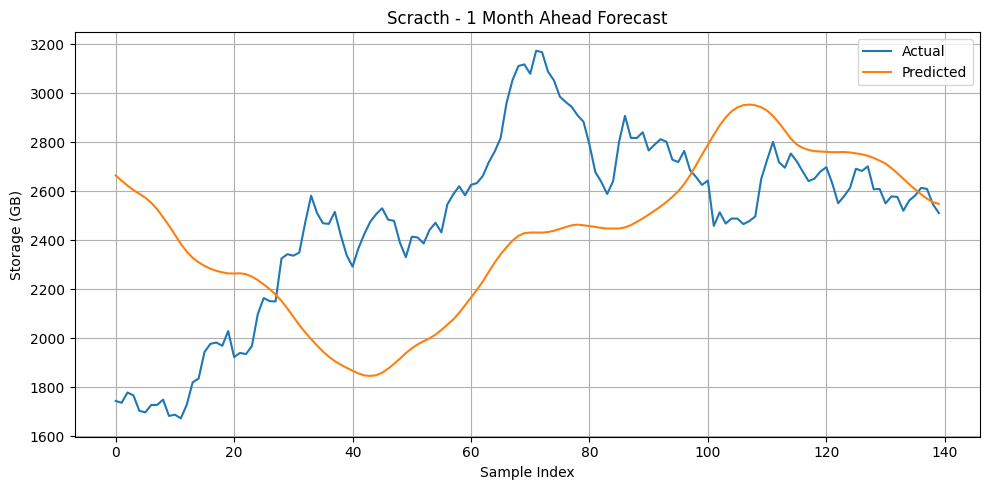

In [35]:
preprocess_and_train_month(scratch_df.copy(), name='Scracth', input_seq_len=30, forecast_offset=30)